<a href="https://colab.research.google.com/github/gshreya5/colab/blob/main/CNN_HotDog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌭 Hot dog or not hot dog

Convolutional Neural Networks

# Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import tensorflow_datasets as tfds

#Data

TensorFlow has the food 101 dataset already. We will use this! https://www.tensorflow.org/datasets/catalog/food101

Hot dog is label 55

In [4]:
ds, ds_info = tfds.load('food101', shuffle_files=True, as_supervised=True, with_info=True)

# Split Data to Train and Validation Sets

In [19]:
train_ds, valid_ds = ds["train"], ds["validation"]

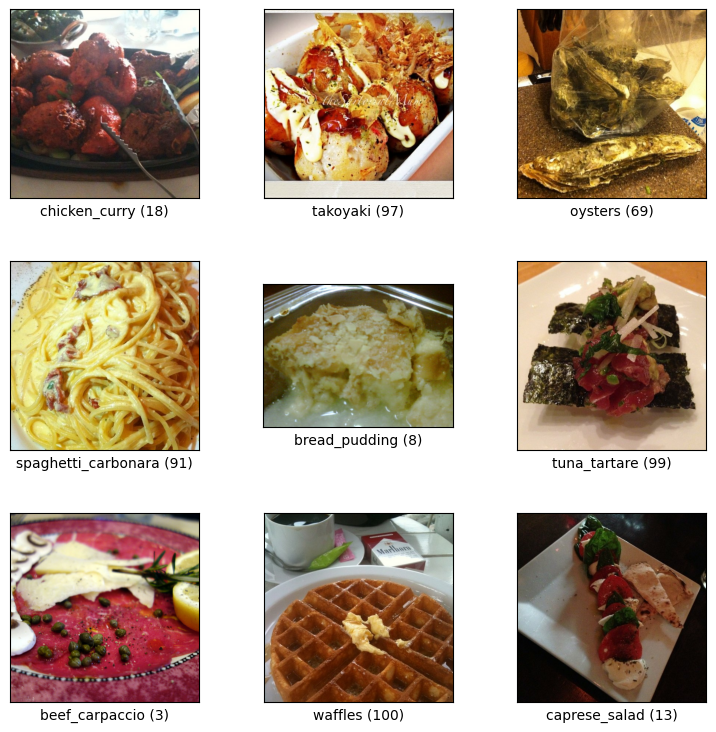

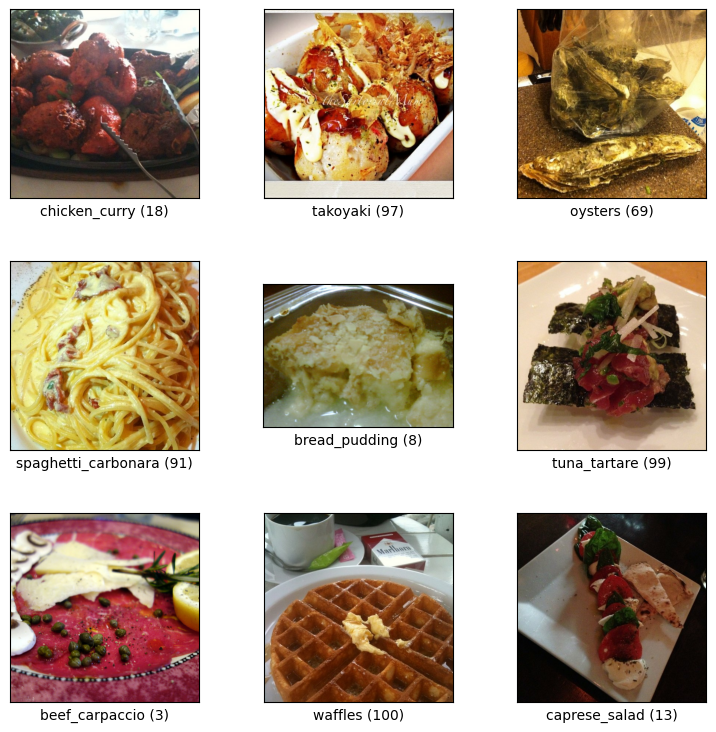

In [ ]:
tfds.show_examples(train_ds, ds_info)

images have diff sizes

change labels to 1, 0 {hot dog, not hot dog}

In [20]:
MAX_SIDE_LEN = 128
HOT_DOG_CLASS = 55
train_ds = train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32),
                          tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32))
)
valid_ds = valid_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32),
                          tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32))
)

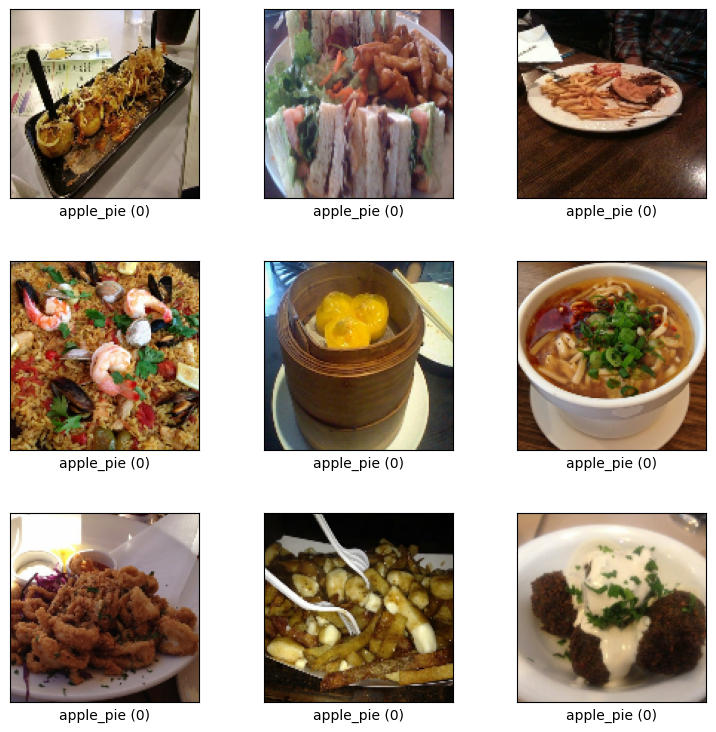

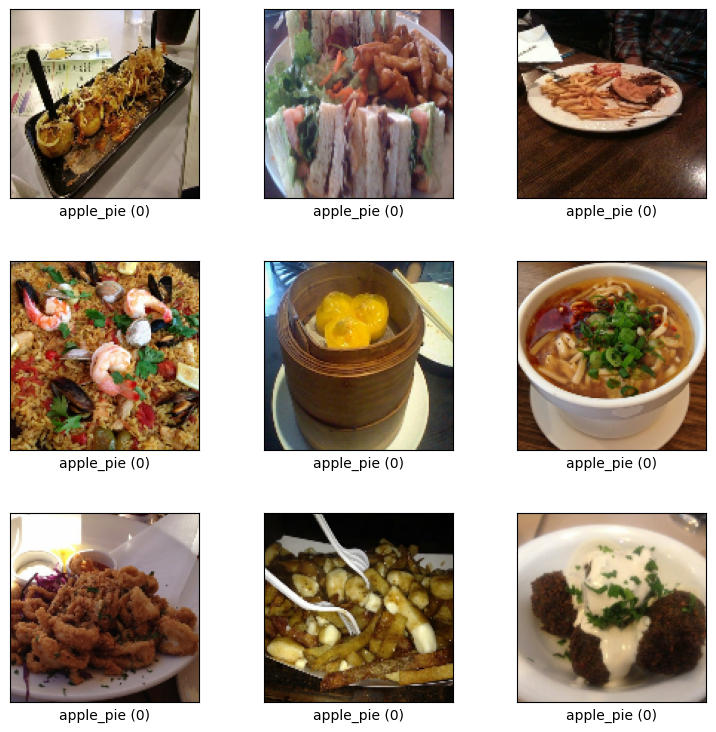

In [21]:
tfds.show_examples(train_ds, ds_info)

apple_pie is 0 for original ds  but here its not hot dog

baby_back_ribs is 1 for original ds but now it indicates a hot dog

In [22]:
train_hd_size, valid_hd_size = 750, 250

train_hd = train_ds.filter(lambda image, label: label == 1).repeat(3).take(train_hd_size)
train_not_hd = train_ds.filter(lambda image, label: label == 0).take(train_hd_size)

valid_hd = valid_ds.filter(lambda image, label: label == 1).repeat(3).take(valid_hd_size)
valid_not_hd = valid_ds.filter(lambda image, label: label == 0).take(valid_hd_size)

In [23]:
batch_size = 16

train_ds = tf.data.Dataset.sample_from_datasets([train_hd, train_not_hd],
                                                [0.5, 0.5],
                                                stop_on_empty_dataset=True)

train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.sample_from_datasets([valid_hd, valid_not_hd],
                                                [0.5, 0.5],
                                                stop_on_empty_dataset=True)

valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [ ]:
for img, label in train_ds.take(1):
  print(img, label)

tf.Tensor(
[[[[ 20   9  10]
   [ 13   5   8]
   [  6   5   7]
   ...
   [ 12   3   5]
   [ 24  14  20]
   [ 35  20  27]]

  [[ 16   9   9]
   [ 14   9  10]
   [  8   5   7]
   ...
   [ 13   5   7]
   [ 23  13  18]
   [ 32  19  23]]

  [[ 16   8   9]
   [ 13   8  10]
   [  9   5   8]
   ...
   [ 25  19  20]
   [ 16   8  10]
   [ 32  21  20]]

  ...

  [[ 18   1   3]
   [ 32  14  14]
   [ 49  25  20]
   ...
   [108  73  52]
   [ 58  21  11]
   [ 49  12   7]]

  [[ 12   4   7]
   [ 11   4   7]
   [ 17   4   5]
   ...
   [ 47  14   5]
   [ 47  12  10]
   [ 47  12  13]]

  [[ 15   4   9]
   [ 10   2  10]
   [ 11   4   8]
   ...
   [ 40   9  10]
   [ 41  10  11]
   [ 40   9   9]]]


 [[[253 255 254]
   [253 254 253]
   [254 254 252]
   ...
   [254 254 254]
   [255 255 255]
   [255 255 255]]

  [[253 254 253]
   [253 255 254]
   [253 255 254]
   ...
   [252 252 252]
   [253 253 253]
   [255 255 255]]

  [[255 255 253]
   [253 255 254]
   [236 240 241]
   ...
   [ 30  30  30]
   [254 254 254]


# Neural Net Implementation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [27]:
random.seed(0)
model = models.Sequential()
model.add(layers.Rescaling(1./255)) # colors -> 0 balck , 1 white
model.add(layers.Conv2D(128,(3,3), activation = "relu", input_shape=(MAX_SIDE_LEN, MAX_SIDE_LEN, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25)) # turn off 25% networks
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1))

In [28]:
lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data = valid_ds,
    epochs = epochs,
    verbose=1
)

Epoch 1/20
93/93 [==============================] - 20s 51ms/step - loss: 1.7964 - accuracy: 0.4943 - val_loss: 1.6122 - val_accuracy: 0.5252
Epoch 2/20
93/93 [==============================] - 3s 37ms/step - loss: 1.4673 - accuracy: 0.4943 - val_loss: 1.3353 - val_accuracy: 0.5252
Epoch 3/20
93/93 [==============================] - 3s 33ms/step - loss: 1.2303 - accuracy: 0.4949 - val_loss: 1.1453 - val_accuracy: 0.5252
Epoch 4/20
93/93 [==============================] - 3s 34ms/step - loss: 1.0718 - accuracy: 0.4983 - val_loss: 1.0138 - val_accuracy: 0.5231
Epoch 5/20
93/93 [==============================] - 3s 34ms/step - loss: 0.9605 - accuracy: 0.5118 - val_loss: 0.9217 - val_accuracy: 0.5231
Epoch 6/20
93/93 [==============================] - 3s 33ms/step - loss: 0.8858 - accuracy: 0.5185 - val_loss: 0.8601 - val_accuracy: 0.5231
Epoch 7/20
93/93 [==============================] - 3s 33ms/step - loss: 0.8280 - accuracy: 0.5320 - val_loss: 0.8138 - val_accuracy: 0.5357
Epoch 8/20
9

In [42]:
history = model.fit(
    train_ds,
    validation_data = valid_ds,
    epochs = epochs,
    verbose=1
)

Epoch 1/20
93/93 [==============================] - 4s 38ms/step - loss: 0.6244 - accuracy: 0.6548 - val_loss: 0.6587 - val_accuracy: 0.6239
Epoch 2/20
93/93 [==============================] - 3s 33ms/step - loss: 0.6122 - accuracy: 0.6703 - val_loss: 0.6602 - val_accuracy: 0.6071
Epoch 3/20
93/93 [==============================] - 3s 34ms/step - loss: 0.5925 - accuracy: 0.6730 - val_loss: 0.6598 - val_accuracy: 0.6134
Epoch 4/20
93/93 [==============================] - 3s 34ms/step - loss: 0.5809 - accuracy: 0.6837 - val_loss: 0.6578 - val_accuracy: 0.6324
Epoch 5/20
93/93 [==============================] - 4s 41ms/step - loss: 0.5676 - accuracy: 0.7087 - val_loss: 0.6585 - val_accuracy: 0.6345
Epoch 6/20
93/93 [==============================] - 4s 39ms/step - loss: 0.5519 - accuracy: 0.7202 - val_loss: 0.6741 - val_accuracy: 0.6555
Epoch 7/20
93/93 [==============================] - 3s 38ms/step - loss: 0.5353 - accuracy: 0.7296 - val_loss: 0.6669 - val_accuracy: 0.6387
Epoch 8/20
93

TypeError: ignored

# Check Against Validation Set

In [44]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in valid_ds.take(1):
  images = image_batch
  labels = label_batch

<Figure size 1000x1000 with 0 Axes>

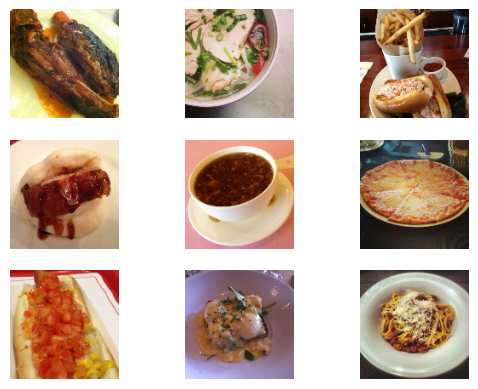

In [45]:
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(images[i])
  plt.axis("off")

In [46]:
labels[:9]

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=int32)>